<a href="https://colab.research.google.com/github/MateoUsme/MelonnTest/blob/main/Melonn_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [2]:
# Data manipulation and general purpose

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Modeling and etrics
#   DARTS, library focused on time serie analysis and forecasting
#   https://unit8co.github.io/darts/index.html

import pmdarima as pmd
from darts import TimeSeries
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    RandomForest
)


import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


First at all we will take a look at our data, there is two columns of interest that are **RequestTime** with the date of every call and **DeliveryOption** that will tell us in wich shift should we put the order to be enlisted after the processing of the data. We can focus on these variables to move forward the analysis.

In [3]:
df = pd.read_csv(r'Datos_Prueba_DataScientist.csv', parse_dates = ['RequestTime'])
df.head()

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm


The column **DeliveryOption** has a text with the time that the order will be delivered, we need to change it with the option that the customer did choose:


Order recorded in call|Option
------------|------------------
Mismo dia entre 6:30 pm y 8:30 pm|Option 1
Siguiente dia entre 12:30 pm y 2:30 pm|Option 2
Siguiente dia entre 6:30 pm y 8:30 pm|Option 3



The first step is replacing the order recorded in the call with the option and after this, we can start to move every option in the calls to the shift where it wil be delivered. Here is the relation between the options and the shift the order should be placed:

Order option|Shift to be placed
------------|------------------
Option 1|Shift 2
Option 2|Shift 1
Option 3|Shift 1

In [4]:
options = {'Mismo dia entre 6:30 pm y 8:30 pm' : 'Option 1',
           'Siguiente dia entre 12:30 pm y 2:30 pm' : 'Option 2',
           'Siguiente dia entre las 6:30 pm y 8:30 pm' : 'Option 3'}

df.DeliveryOption = df.DeliveryOption.replace(options)
df

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Option 1
1,PED_2,2018-01-01 08:28:55,Option 1
2,PED_3,2018-01-01 08:39:08,Option 1
3,PED_4,2018-01-01 09:25:07,Option 2
4,PED_5,2018-01-01 09:36:25,Option 2
...,...,...,...
153270,PED_153271,2021-02-28 17:19:26,Option 2
153271,PED_153272,2021-02-28 17:19:37,Option 2
153272,PED_153273,2021-02-28 17:43:56,Option 3
153273,PED_153274,2021-02-28 17:53:28,Option 3


To ensure the integrity of the calls with the Option 1, that is only allowed to be requested from 8AM to 12 PM, we filter by this option and it shows that the calls were done in the exptected range of time.

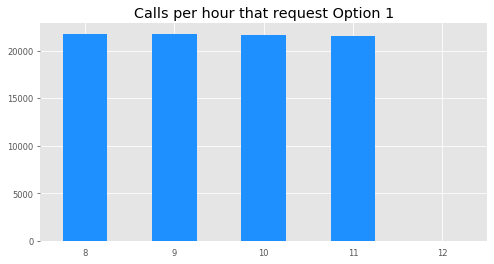

In [5]:
df[df.DeliveryOption == 'Option 1'].RequestTime.dt.hour.value_counts().plot.bar(figsize=(8,4), color='dodgerblue');
plt.title('Calls per hour that request Option 1');
plt.xticks(rotation=0);

Plotting valuable information can help us to understand more the dynamic with the amount of orders that the **pickers** need to enlist for each Shift.

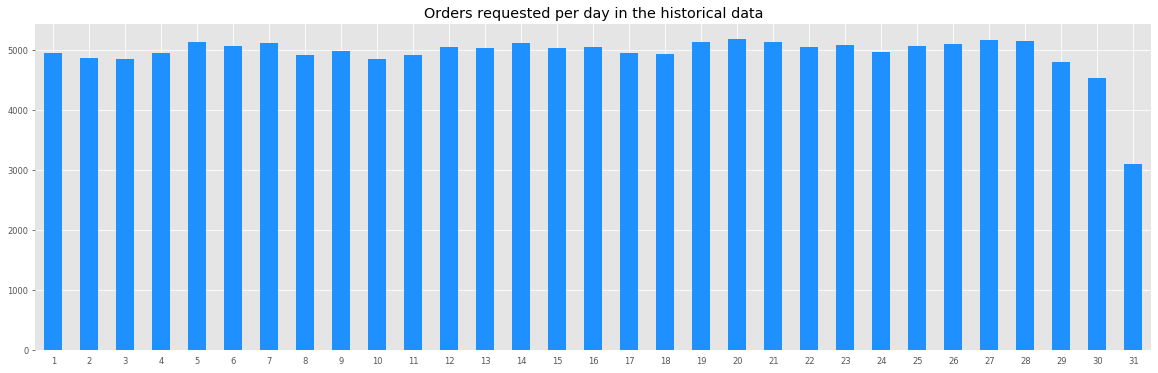

In [6]:
df.RequestTime.dt.day.sort_values().value_counts(sort=False).plot.bar(figsize=(20,6), color='dodgerblue');
plt.title('Orders requested per day in the historical data');
plt.xticks(rotation=0);

There is a clear decrease of orders recorded in calls at the end of the month, the day 31 cannot be counted because not all months have 31 days but they all have 30 excluding February.

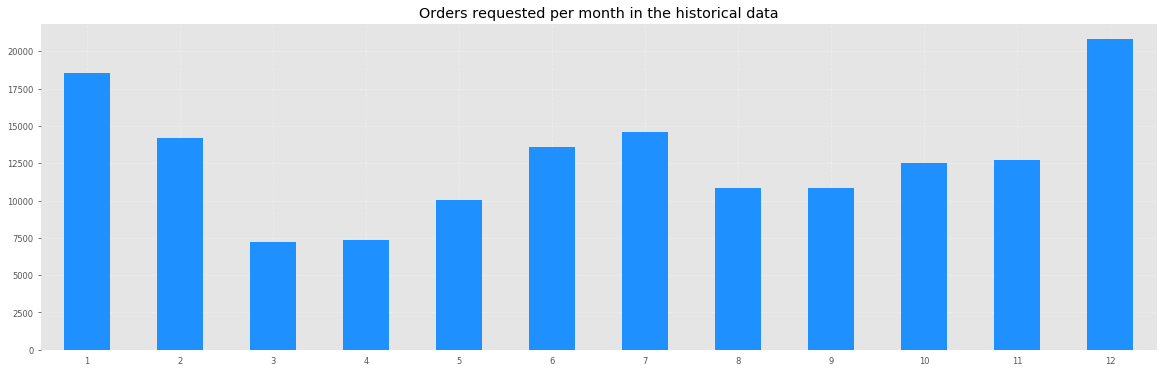

In [7]:
df.RequestTime.dt.month.sort_values().value_counts(sort=False).plot.bar(figsize=(20,6), color='dodgerblue');
plt.title('Orders requested per month in the historical data');
plt.grid(linestyle='--', alpha=0.3);
plt.xticks(rotation=0);

But if we take a moment to look the count of total calls by month there is a pattern where in the mid of the year and the start of him the orders increase a lot, specially in December, January and February!

# Data Processing

It's time to separate the orders placed along the days in every Shift, the options are distributed to work individually with each one:

In [8]:
df = pd.concat([df, df.pivot(columns = ['DeliveryOption'], values = ['DeliveryOption']).DeliveryOption],axis = 1)
df.set_index('RequestTime', drop=True, inplace=True)
df.head(10)

,OrderId,DeliveryOption,Option 1,Option 2,Option 3
RequestTime,,,,,
2018-01-01 08:03:12,PED_1,Option 1,Option 1,NaN,NaN
2018-01-01 08:28:55,PED_2,Option 1,Option 1,NaN,NaN
2018-01-01 08:39:08,PED_3,Option 1,Option 1,NaN,NaN
2018-01-01 09:25:07,PED_4,Option 2,NaN,Option 2,NaN
2018-01-01 09:36:25,PED_5,Option 2,NaN,Option 2,NaN
2018-01-01 10:21:53,PED_6,Option 1,Option 1,NaN,NaN
2018-01-01 10:27:17,PED_7,Option 1,Option 1,NaN,NaN
2018-01-01 10:48:53,PED_8,Option 1,Option 1,NaN,NaN
2018-01-01 11:13:10,PED_9,Option 1,Option 1,NaN,NaN


Next step is to sumarize the calls by days and counting the orders by options:

In [9]:
df = df.resample('D').count()[['Option 1', 'Option 2','Option 3']]
df

,Option 1,Option 2,Option 3
RequestTime,,,
2018-01-01,8,5,5
2018-01-02,7,7,5
2018-01-03,8,7,5
2018-01-04,9,6,4
2018-01-05,9,7,6
...,...,...,...
2021-02-24,91,57,25
2021-02-25,91,50,20
2021-02-26,118,73,25


And finally we can separate the options with the most complete data per day in both shifts:

In [10]:
df['Shift 1'] = df['Option 2'].shift(1) + df['Option 3'].shift(1)
df['Shift 2'] = df['Option 1']
df = df.filter(['Shift 1', 'Shift 2']).dropna()
df

,Shift 1,Shift 2
RequestTime,,
2018-01-02,10.0,7
2018-01-03,12.0,8
2018-01-04,12.0,9
2018-01-05,10.0,9
2018-01-06,13.0,16
...,...,...
2021-02-24,76.0,91
2021-02-25,82.0,91
2021-02-26,70.0,118


To ensure the amount of pickers needed for every month first we need to:

 

1.   Calculate the mean of order to be enlisted per shift in every week
2.   Take the maximun value from the weeks of every month to ensure that the orders will be covered in every shift without problem month by month
3. Divide the result by 30 because every Shift have 6 hours of work and every picker should have a work ratio of 5 order picked per hour, so this division results in the number of pickers needed for that month.



In [11]:
df_monthly = df.resample('W').mean().resample('M').max()/30
df_monthly.head()

,Shift 1,Shift 2
RequestTime,,
2018-01-31,0.533333,0.438095
2018-02-28,0.461905,0.466667
2018-03-31,0.523810,0.580952
2018-04-30,0.590476,0.690476
2018-05-31,0.685714,0.790476


We need to consider the pandemic affectedness on the requests during the most affected months so we aggregate this factor to our data:

In [12]:
def pandemic_affect(df_i):

    #Creates a new column in the dataframe with the values of the affectedness to te company in pandemic period.
    df_i.loc[(df_i.index < '2020-03-01'), 'Pandemic Affect'] = 0
    df_i.loc[(df_i.index >= '2020-03-01') & (df_i.index < '2020-05-01'), 'Pandemic Affect'] = 3
    df_i.loc[(df_i.index >= '2020-05-01') & (df_i.index < '2020-08-01'), 'Pandemic Affect'] = 1
    df_i.loc[(df_i.index >= '2020-08-01') & (df_i.index < '2020-10-01'), 'Pandemic Affect'] = 2
    df_i.loc[(df_i.index >= '2020-10-01') & (df_i.index < '2020-12-01'), 'Pandemic Affect'] = 1
    df_i.loc[(df_i.index >= '2020-12-01') & (df_i.index < '2021-02-01'), 'Pandemic Affect'] = 2
    df_i.loc[(df_i.index >= '2021-02-01'), 'Pandemic Affect'] = 1
    return df_i

In [13]:
df_monthly = pandemic_affect(df_monthly)
df_monthly.tail()

,Shift 1,Shift 2,Pandemic Affect
RequestTime,,,
2020-10-31,2.714286,3.685714,1.0
2020-11-30,2.895238,3.985714,1.0
2020-12-31,4.195238,5.514286,2.0
2021-01-31,3.785714,4.961905,2.0
2021-02-28,3.200000,4.266667,1.0


# Training

And so on, moving forward the analysis we will test some models to forecast the next month and use the recommendation of the best model to hire the enough amount of pickers and minimize the waste of money exceeding the personal.

First at all, the models will be proved predicting the last two months of the data:

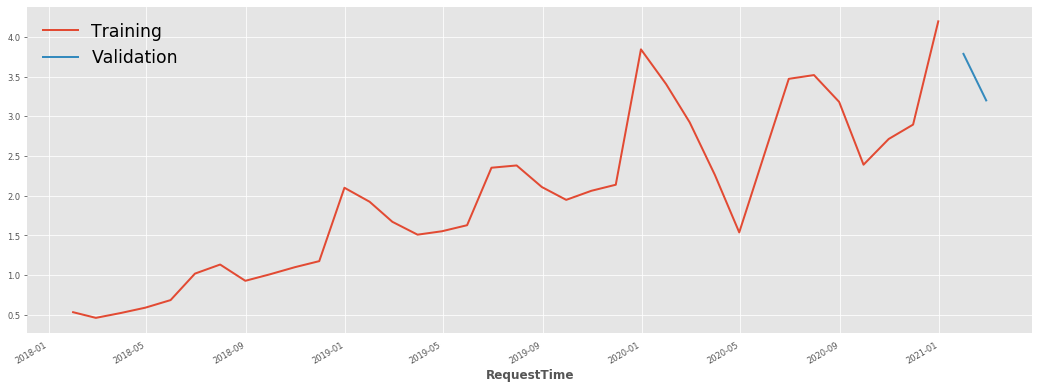

In [14]:
series = TimeSeries.from_dataframe(df_monthly['Shift 1'].to_frame())
train, val = series.split_before(0.999)
plt.figure(figsize=(18,6))
train.plot(label="Training")
val.plot(label="Validation")
plt.legend(loc="upper left", fontsize="xx-large")

Initially if we have stationality in the data the models will have a considerable help while predicting, this data have stationality:

In [15]:
ALPHA = 0.05

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("There is stationality? " + str(is_seasonal))
if is_seasonal:
    print('Yes, it order is {}.'.format(mseas))
else:
  print("No, there isn't")

There is stationality? True
Yes, it order is 6.


We need to train the models calculating with a variety of error metrics the performance of each one predicting the last two months of our data:

In [16]:
def eval_model(model):
    t_start =  time.perf_counter()


    # Fit and predict of every model with the past division of train and validation
    res = model.fit(train)
    forecast = model.predict(len(val))

    # fFor Naive Forecast we add the Trend and Seasonality component if there is one
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    # Calculate measuring metrics for every prediction
    
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    return results

In [17]:
m_naive = NaiveDrift();

#-----

if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas);
else:
    m_expon = ExponentialSmoothing();

#-----

y = np.asarray(series.pd_series())
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2);
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2);
n_diff = max(n_adf, n_kpss)

n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y);
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y);
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

#-----

m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto");

#-----

thetas = 2 - np.linspace(-10, 10, 100)
best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta);
    res = model.fit(train);
    pred_theta = model.predict(len(val));
    res_mape = mape(val, pred_theta);

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta) ;

#-----

m_randomforest = RandomForest(lags=20, n_estimators = 10, max_depth = 5);


#------
#------

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_randomforest]

In [18]:
# call the forecasters one after the other
model_titles = ['Exponential Smoothing','Theta','ARIMA','NAIVE','Random Forest']
model_predictions = [eval_model(model) for model in models];

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,0)[6]             : BIC=40.558, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[6]             : BIC=41.491, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[6]             : BIC=32.558, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[6]             : BIC=34.967, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[6]             : BIC=37.193, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[6]             : BIC=35.125, Time=0.23 sec
 ARIMA(1,1,0)(1,1,1)[6]             : BIC=35.312, Time=0.63 sec
 ARIMA(1,1,0)(0,1,1)[6]             : BIC=35.424, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[6]             : BIC=38.368, Time=1.03 sec
 ARIMA(0,1,0)(1,1,0)[6]             : BIC=31.460, Time=0.16 sec
 ARIMA(0,1,0)(2,1,0)[6]             : BIC=34.612, Time=0.27 sec
 ARIMA(0,1,0)(1,1,1)[6]             : BIC=34.630, Time=0.45 sec
 ARIMA(0,1,0)(0,1,1)[6]             : BIC=35.682, Time=0.28 sec
 ARIMA(0,1,0)(2,1,1)[6]             : BIC=37.961, Time=0.81 sec
 ARIMA(0,1,1)(1,1,0)[6]             : BIC=31.035, Time=0.20 s

# Results

Now run the forecasters and tabulate their prediction accuracy and processing time to find the best model performance:

In [19]:
df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = ['Exponential Smoothing']

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [model_titles[i]]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="green", axis=1).highlight_max(color="darkorange", axis=1)

,Exponential Smoothing,Theta,ARIMA,NAIVE,Random Forest
MAPE,8.337,2.297,10.262,5.112,7.254
MAE,0.276,0.079,0.349,0.176,0.270
R squared,0.178,-0.926,0.498,-0.636,0.397
RMSE,0.318,0.079,0.358,0.177,0.346
RMSLE,0.072,0.018,0.079,0.040,0.076
time,0.324,0.139,9.534,0.234,0.182


As we see, the Theta model is the best model based on the error metrics specially compared to the remaining models, if we can visuallize it would be more comfortable to deduce the general performance:

2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-05-02 04:39:10 matplotlib.legend WARNING: No handles with labels found to put in legend.


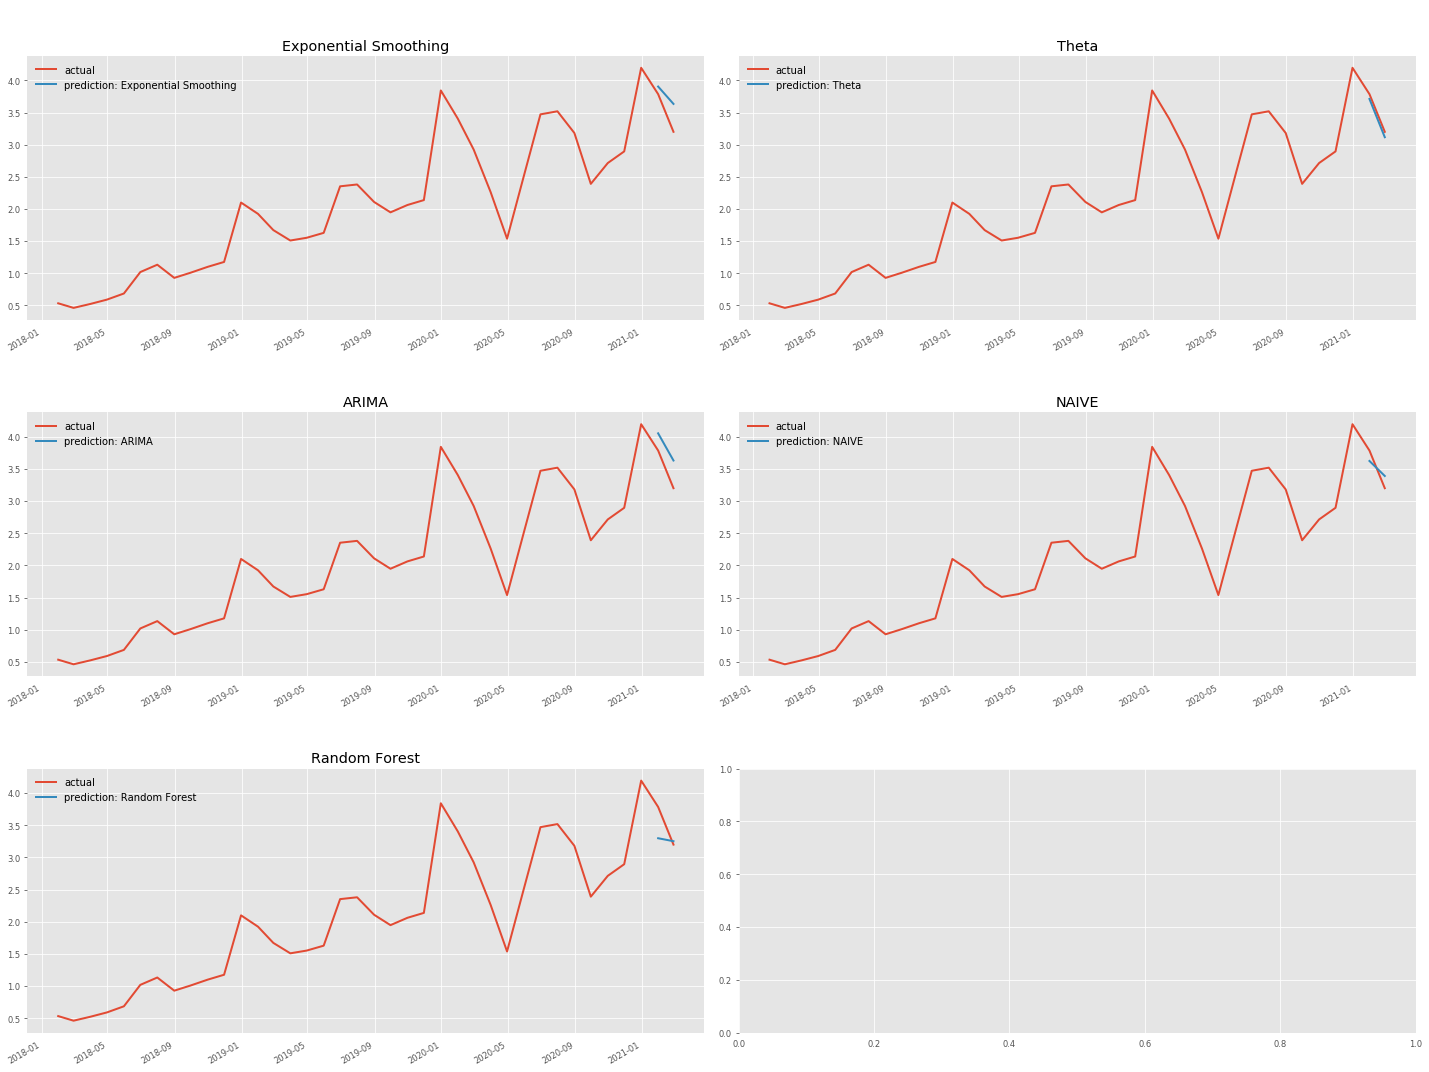

In [20]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

model_titles = ['Exponential Smoothing','Theta','ARIMA','NAIVE','Random Forest']

for i,m in enumerate(models):
        series.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+model_titles[i], ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + model_titles[i])

        ax[i].set_xlabel("")
        ax[i].legend()

plt.tight_layout()

The theta model is the one with the best performance, this model does not allow exogenous variables (coravirables like the pandemic afectedness) becauseo of being univariable forecasting, then we can forecast our next month training this model with all the dataset:

In [21]:
m_theta.fit(series)
m_theta.predict(1).values

<bound method TimeSeries.values of <TimeSeries (DataArray) (RequestTime: 1, component: 1, sample: 1)>
array([[[2.49992359]]])
Coordinates:
  * RequestTime  (RequestTime) datetime64[ns] 2021-03-31
  * component    (component) object 'Shift 1'
Dimensions without coordinates: sample>

For the month of MARCH 2021 the pickers needed to attend the demand of pickers will be **3** if we round the 2.499 **that means the necessity of 2 workers and one more to complete the remainig work**.

# Extra

After our selection, we will add the data of the pandemic affectedness into the Random Forest model that allow variables that can relate the behavior of the information, this to adjust our model to reality and forecast a more accurate value for the next month, this was proved before and the performance increase with this exogenous variable (called covariable too):

In [22]:
series_pandemic = TimeSeries.from_dataframe(df_monthly['Pandemic Affect'].to_frame())
m_randomforest = RandomForest(lags=20, n_estimators = 10, max_depth = 5, lags_past_covariates=30)
m_randomforest.fit(series, past_covariates=series_pandemic)
prediction = m_randomforest.predict(1, past_covariates=series_pandemic)
prediction.values

<bound method TimeSeries.values of <TimeSeries (DataArray) (RequestTime: 1, component: 1, sample: 1)>
array([[[2.78428571]]])
Coordinates:
  * RequestTime  (RequestTime) datetime64[ns] 2021-03-31
  * component    (component) object 'Shift 1'
Dimensions without coordinates: sample>

The random forest with the influence of pandemic level of affectedness shows a result of **3 pickers** in an aproximation too.